# Модель-пример с обновлённым датасетом(OverSampling)

#### Импорт необходимых библиотек

In [2]:
import sys

import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import torchvision as tv
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from livelossplot import PlotLossesKeras

sys.path.append('../../')

from core.datasets import get_ds
from core.make_answer import make_ans_file

#### Формируем аугментацию.

##### Вариант 1.

- Пишите аугментацию. Объект класса tv.transforms.Compose или tv.transforms.{аугментация}

In [3]:
transformer = tv.transforms.Compose([
    tv.transforms.RandomPosterize(bits=6, p=0.4),
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-15, 15), translate=(0, 0.1), scale=(0.85, 1)),
])

##### Вариант 2. (Лиза добавила крутую возможность)
- Пишите несколько агументаций как из варианта два
- Все их записываете в список

Получается так, что для каждого изображения применяется рандомный вариант аугментации, из вами написанных.

Зачем это сделано: Есть некоторые варианты агументации, в которых нет параметра вероятности. Получается так, что Grayscale делает весь трейновый датасет черно-белым, а валидационный и тестовый все такие же разноцветные. То есть в этом случае мы модель не знает, что картинки разноцветные.

`Про варианты агументации и подбор параметров написано в notebooks/skewbek/Augmentation. Всем ознакомиться. (Можно просто делать копипаст комбинаций оттуда)`

In [3]:
# transformer1 = tv.transforms.Compose([
#     tv.transforms.RandomInvert(p=0.4),
#     tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
# ])
# transformer2 = tv.transforms.Compose([
#     tv.transforms.RandomPosterize(bits=6, p=0.4),
#     tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
#     tv.transforms.RandomAffine(degrees=(-15, 15), translate=(0, 0.1), scale=(0.85, 1)),
# ])
# transformer3 = tv.transforms.Compose([
#     tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
#     tv.transforms.RandomAffine(degrees=(-15, 15), translate=(0, 0.1), scale=(0.85, 1)),
#     tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
# ])
# transformer = [transformer1, transformer2, transformer3]

#### Создаем датасеты
```python
get_ds(
    file_train, `Путь к трейновому датасету`
    file_test, `Путь к тестовому датасету`
    transform=None,  `Аугументация`
    batch_size=512,  `Размер батча`
    one_hot=False,  `Формат ответов one_hot_encoding или нет`
    val_size=0.03,  `Размер валидационного датасета, относительно data_train`
    back=1,  `На сколько уровней в директории надо подняться наверх, чтобы дойти до корневой`
)
```

Позже мы будем делать ансамбли и похожие эвристики, поэтому всегда делайте `one_hot=True`

In [44]:
train_ds, val_ds, test_ds = get_ds('smote_data_train_9650', 'repaired_data_test', transform=transformer, one_hot=True, back=2)

Для дальнейшей проверки метрик разделяем валидационный датасет на x и y

In [5]:
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])

Смотрим на получившуюся агументацию.

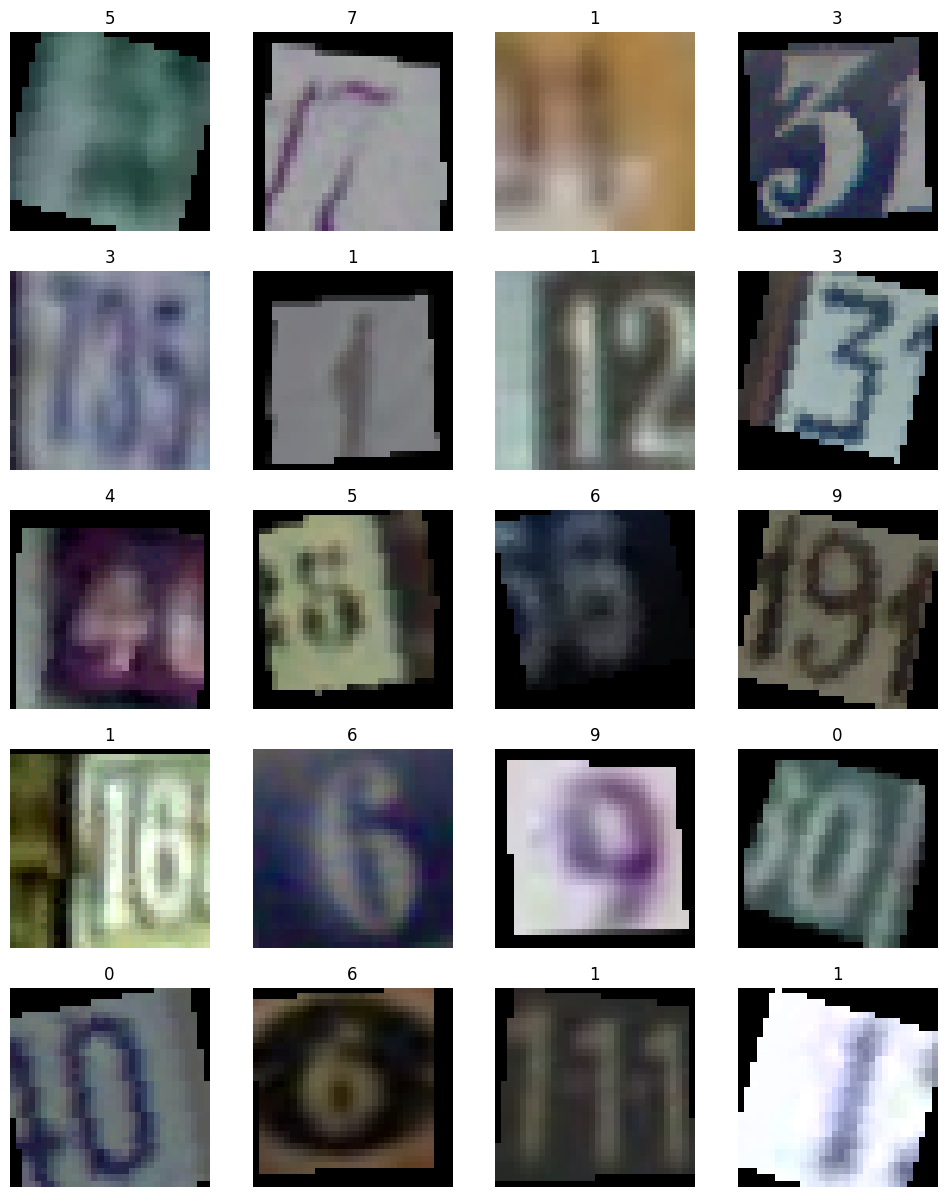

In [6]:
plt.figure(figsize=(12, 15))
train_ds_visualization = train_ds[0]
for i in range(20):
    plt.subplot(5, 4, i + 1)
    img = np.array(Image.fromarray((train_ds_visualization[0][i] * 255).astype(np.uint8), 'RGB'))
    plt.imshow(img / 255, cmap=plt.cm.binary)
    plt.title(np.argmax(train_ds_visualization[1][i]))
    plt.axis('off')
plt.show()

#### Пишем модель

Про свертки и пуллинги написано у Гриши, про skip-connection написано у Миши

Для правильного использования ансамблирования, в финальном слое не пишем функцию активации. Подробнее написано у Дениса.

In [9]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(32, 32, 3), batch_size=512),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0,2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10),
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (512, 30, 30, 32)         896       
                                                                 
 conv2d_11 (Conv2D)          (512, 28, 28, 64)         18496     
                                                                 
 batch_normalization_3 (Batc  (512, 28, 28, 64)        256       
 hNormalization)                                                 
                                                                 
 average_pooling2d_5 (Averag  (512, 14, 14, 64)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_12 (Conv2D)          (512, 12, 12, 128)        73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (512, 6, 6, 128)        

#### Создаем чекпоинты (всем уже рассказал)
- Если лень, то просто копипаст того, что я написал ниже. НЕ ЗАБЫВАЕМ МЕНЯТЬ ПЕРЕМЕННУЮ `num_model`!!!

In [11]:
metrics = ['categorical_accuracy',
           tfa.metrics.F1Score(num_classes=10, average='macro', name='f1_score')]
num_model = '_s_2'
callbacks = [
    PlotLossesKeras(),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    ),

    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    )
]

#### Компиляция модели
- Если будете что то менять, то только оптимизатор. Про оптимизаторы написано у Лизы.

In [12]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam()),
    metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)

#### Обучаем модель

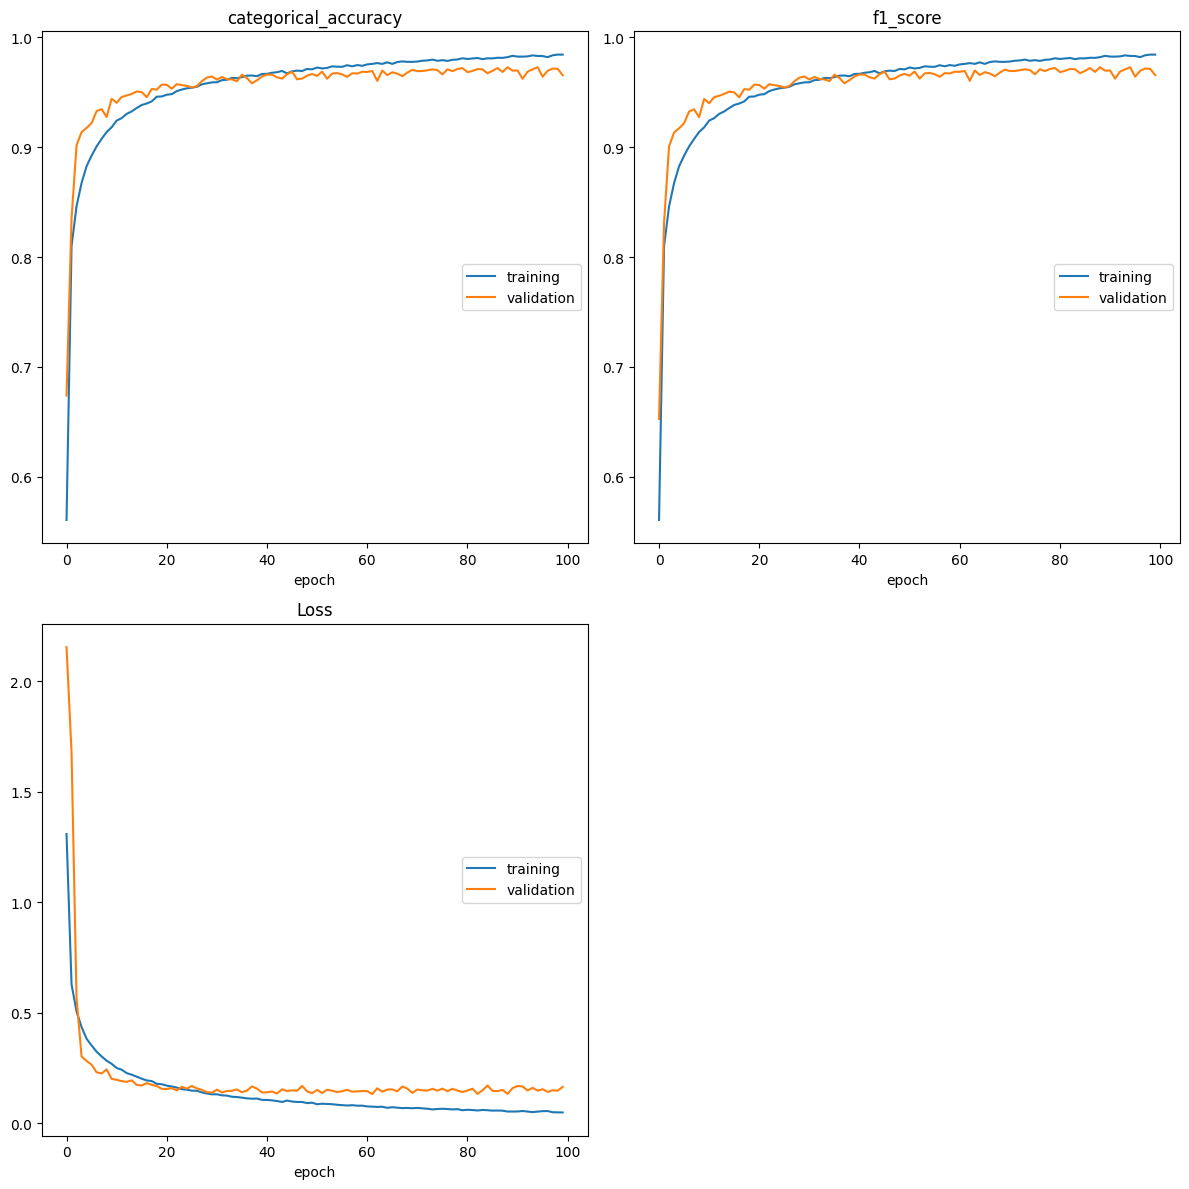

categorical_accuracy
	training         	 (min:    0.561, max:    0.984, cur:    0.984)
	validation       	 (min:    0.674, max:    0.973, cur:    0.966)
f1_score
	training         	 (min:    0.561, max:    0.984, cur:    0.984)
	validation       	 (min:    0.653, max:    0.973, cur:    0.966)
Loss
	training         	 (min:    0.049, max:    1.309, cur:    0.049)
	validation       	 (min:    0.132, max:    2.154, cur:    0.165)
176/176 [==============================] - 202s 1s/step - loss: 0.0488 - categorical_accuracy: 0.9842 - f1_score: 0.9842 - val_loss: 0.1645 - val_categorical_accuracy: 0.9655 - val_f1_score: 0.9656


In [13]:
model.fit(train_ds, validation_data=val_ds,
            epochs=100, callbacks=callbacks, verbose=1)

Подгружаем все чекпоинты

In [14]:
model_categorical_acc = tf.keras.models.load_model(f'../checkpoints/model{num_model}_categorical_accuracy.h5')
model_f1_score = tf.keras.models.load_model(f'../checkpoints/model{num_model}_f1_score.h5')
model_loss = tf.keras.models.load_model(f'../checkpoints/model{num_model}_loss.h5')
model_avg_categorical_acc = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5')
model_avg_f1_score = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_f1_score.h5')
model_avg_loss = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_loss.h5')

У нас поличилось три чекпоинта (три модели). Ниже указан код для получения ответов для всех чекпоинтов по валидационному датасету.

In [15]:
ans_val_categorical_accuracy = make_ans_file(model_categorical_acc, val_ds_x)
ans_val_f1_score = make_ans_file(model_f1_score, val_ds_x)
ans_val_loss = make_ans_file(model_loss, val_ds_x)
ans_val_avg_categorical_accuracy = make_ans_file(model_avg_categorical_acc, val_ds_x)
ans_val_avg_f1_score = make_ans_file(model_avg_f1_score, val_ds_x)
ans_val_avg_loss = make_ans_file(model_avg_loss, val_ds_x)
anss = [ans_val_categorical_accuracy, ans_val_f1_score, ans_val_loss, ans_val_avg_categorical_accuracy, ans_val_avg_f1_score, ans_val_avg_loss]

Формируем валидационные ответы.

In [16]:
val_ds_y = np.argmax(val_ds_y, axis=1)

Сравниваем валидационные предикты каждого чекпоинта

In [17]:
for i in range(len(anss) - 1):
    for j in range(i + 1, len(anss)):
        if np.all(anss[i] == anss[j]):
            print(f'чекпоинты {i + 1} и {j + 1} одинаковые')

чекпоинты 1 и 2 одинаковые
чекпоинты 4 и 5 одинаковые


`Все ответы разные, значит чекпоинты сохранили модель на разных эпохах. Если ответы будут одинковые, то вывод о чекпоинте делать не надо.`

- Денис пишет ансамблинг моделей. Когда он допишет, мы применим это для формирования ответа по трем получившимся моделям. То есть, если все чекпоинты разные, то мы будем делать средний ответ по трем предиктам.

В конце смотрим на метрики и делаем выводы о том, чем хороша эта модель. Какие классы она угадывает лучше/худше всего. Дописываем какую метрику показал kaggle.

In [18]:
class MulticlassClassificationMetrics:
    def __init__(self, y_true, y_pred):
        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)
        self.matrix_error = self.get_matrix_error()

    def get_matrix_error(self):
        self.class_types = np.unique([self.y_true, self.y_pred])
        TP, FN, FP, TN = [], [], [], []
        for class_type in self.class_types:
            TP.append(np.sum(np.logical_and(self.y_true == self.y_pred, self.y_true == class_type)))
            FN.append(np.sum(np.logical_and(self.y_true == class_type, self.y_pred != class_type)))
            FP.append(np.sum(np.logical_and(self.y_pred == class_type, self.y_true != class_type)))
            TN.append(np.sum(np.logical_and(self.y_pred != class_type, self.y_true != class_type)))
        return pd.DataFrame({
            'class_type': self.class_types,
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        }).set_index('class_type')

    def accuracy(self):
        return np.sum(self.y_true == self.y_pred) / self.y_true.shape[0]

    def precision(self, averaging='macro'):
        if averaging == 'macro':
            precisions = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FP'])
            return np.mean(precisions.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FP'])

    def recall(self, averaging='macro'):
        if averaging == 'macro':
            recalls = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FN'])
            return np.mean(recalls.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FN'])

    def f1_score(self, averaging='macro'):
        if averaging == 'macro':
            reverse_r = (self.matrix_error['TP'] + self.matrix_error['FN']) / self.matrix_error['TP']
            reverse_p = (self.matrix_error['TP'] + self.matrix_error['FP']) / self.matrix_error['TP']
            f1_scores = 2 / (reverse_r + reverse_p)
            return np.mean(f1_scores.replace(np.nan, 0))
        elif averaging == 'micro':
            p = self.precision(averaging)
            r = self.recall(averaging)
            return 2 * p * r / (p + r)

    def metrics(self, averaging='macro'):
        return {
            'accuracy': self.accuracy(),
            'precision': self.precision(averaging),
            'recall': self.recall(averaging),
            'f1_score': self.f1_score(averaging),
        }

    def __str__(self):
        headers = {
            'selector': '*',
            'props': 'background-color: darkgreen; color: white; font-size: 12pt;',
        }
        che_super_mega_puper_visualization_of_cell = { 
            'selector': 'td:hover',
            'props': 'background-color: green; color: white;',
        }
        display(
            self.matrix_error
            .style
            .set_table_styles([
                headers,
                che_super_mega_puper_visualization_of_cell,
            ])
            .set_properties(**{'background-color': 'lightgreen',
                           'color': 'black', 'font-size': '12pt'})
        )
        return ''

    def __repr__(self):
        return (
            f'MulticlassClassificationMetrics(class_types={self.class_types})'
            .replace("'", '').replace(',', ';'))

C:\Users\Mihail\PycharmProjects\YaMlProject\venv\lib\site-packages\matplotlib\cbook\__init__.py:1399: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xi = np.asanyarray(xi)


ValueError: could not broadcast input array from shape (512,32,32,3) into shape (512,)

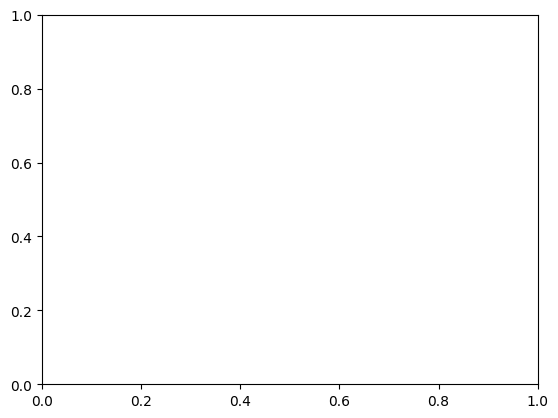

In [17]:
plt.hist(val_ds)

### Accuracy чекпоинт

In [19]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_categorical_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,669,6065,10,12
1,680,6012,29,35
2,663,6041,25,27
3,618,6086,30,22
4,646,6083,13,14
5,663,6053,16,24
6,652,6074,17,13
7,671,6063,10,12
8,628,6100,14,14


{'accuracy': 0.9727649496743636,
 'precision': 0.9728053119221507,
 'recall': 0.9728977464107098,
 'f1_score': 0.9728371695700687}

- $FP_1=15$. То есть, модель предсказала 15 раз 1, когда на самом деле там была не 1. Наверное модель плохо различает 1 и 7.
- $FN_1=15$. То есть, модель 15 раз ошиблась, когда угадывала 1.

Метрики более менее хоршие. Переобучения нет. Ставить модель на больше эпох нет смысла, потому что последние 50 эпох модель практически не меняла веса.

`Это не шаблон!!! Писать надо как сами посчитаете`

### Loss чекпоинт

In [20]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_loss)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,669,6061,14,12
1,677,6009,32,38
2,664,6040,26,26
3,603,6096,20,37
4,639,6088,8,21
5,667,6046,23,20
6,644,6076,15,21
7,676,6056,17,7
8,633,6081,33,9


{'accuracy': 0.9693605683836589,
 'precision': 0.9694745037839476,
 'recall': 0.9693873514777801,
 'f1_score': 0.9693613520576643}

- $FN_1=28$.
- $FP_1=19$.
- $FP_2=18$.
- $FP_3=18$.
- $FN_3=16$.
- $FN_8=15$.

Модель очень плохо справляется с единицами. Так же можно сказать что 2 и 3 модель часто угадывает ложно.

Метрики хуже, чем у accuracy чекпоинта. Но все равно посмотрим, что скажут метрики kaggle.

### F1-score чекпоинт

In [21]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_f1_score)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,669,6065,10,12
1,680,6012,29,35
2,663,6041,25,27
3,618,6086,30,22
4,646,6083,13,14
5,663,6053,16,24
6,652,6074,17,13
7,671,6063,10,12
8,628,6100,14,14


{'accuracy': 0.9727649496743636,
 'precision': 0.9728053119221507,
 'recall': 0.9728977464107098,
 'f1_score': 0.9728371695700687}

- $FN_1=19$.
- $FP_2=19$.

Модель плохо справляется с единицами и двойками.

Метрики неплохие.

### Среднее скользящее по accuracy чекпоинт

In [22]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_categorical_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,674,6063,12,7
1,682,6014,27,33
2,670,6045,21,20
3,615,6098,18,25
4,645,6085,11,15
5,665,6049,20,22
6,652,6077,14,13
7,675,6063,10,8
8,632,6098,16,10


{'accuracy': 0.9755772646536413,
 'precision': 0.9756366910412468,
 'recall': 0.975661433850815,
 'f1_score': 0.9756387610242843}

### Среднее скользящее по f1-score чекпоинт

In [23]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_f1_score)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,674,6063,12,7
1,682,6014,27,33
2,670,6045,21,20
3,615,6098,18,25
4,645,6085,11,15
5,665,6049,20,22
6,652,6077,14,13
7,675,6063,10,8
8,632,6098,16,10


{'accuracy': 0.9755772646536413,
 'precision': 0.9756366910412468,
 'recall': 0.975661433850815,
 'f1_score': 0.9756387610242843}

### Среднее скользящее по loss чекпоинт

In [24]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_loss)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,673,6063,12,8
1,684,6005,36,31
2,665,6043,23,25
3,609,6095,21,31
4,644,6088,8,16
5,668,6054,15,19
6,646,6077,14,19
7,672,6059,14,11
8,634,6097,17,8


{'accuracy': 0.9733570159857904,
 'precision': 0.9735221688409819,
 'recall': 0.9733873718300995,
 'f1_score': 0.9734323072672624}

- Сохраняем ответы.

In [51]:
transformer = tv.transforms.Compose([
    tv.transforms.RandomPosterize(bits=6, p=0.4),
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5)
])

In [52]:
img = lambda x: np.array(transformer(Image.fromarray((x * 255).astype(np.uint8), 'RGB')))
test_ds_tr = np.array([img(x) for x in test_ds])
test_ds_tr.shape

(25000, 32, 32, 3)

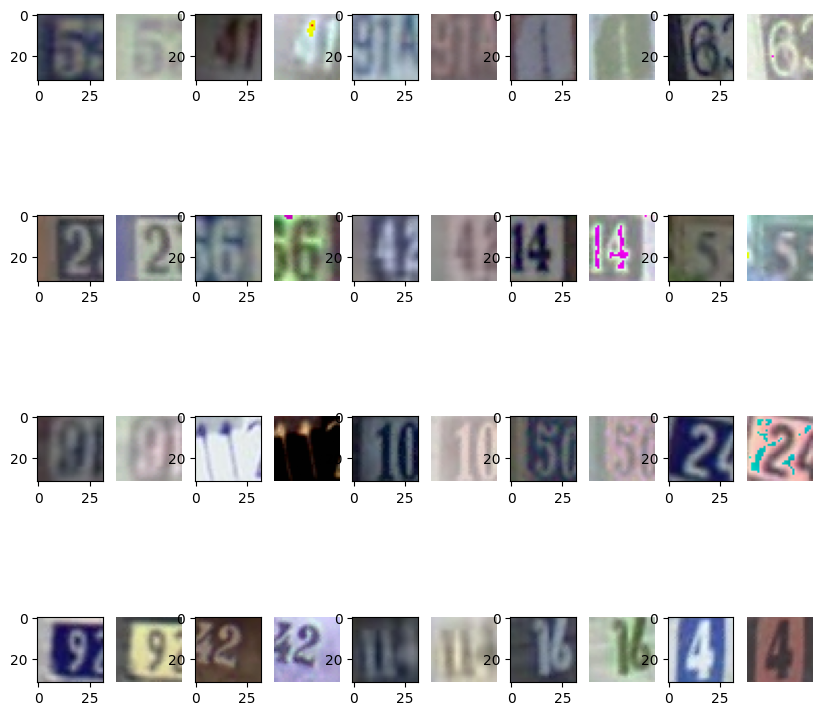

In [57]:
def draw_aug_ds(transformer):
    plt.figure(figsize=(10, 10))
    for i in range(20):
        plt.subplot(4, 10, 2 * i + 1)
        if transformer:
            img = np.array(transformer(Image.fromarray((test_ds[i] * 255).astype(np.uint8), 'RGB')))
            img2 = np.array(transformer(Image.fromarray((test_ds_tr[i] * 255).astype(np.uint8), 'RGB')))
        else:
            img = test_ds[i] * 255
            img2 = test_ds_tr[i] * 255
        plt.imshow(img / 255, cmap=plt.cm.binary)
        plt.subplot(4, 10, 2 * i + 2)
        plt.imshow(img2 / 255, cmap=plt.cm.binary)
        # plt.title(train_ds[i][1][0])
        plt.axis('off')
    plt.show()

draw_aug_ds(None)

In [56]:
ans_test_categorical_accuracy = make_ans_file(model_categorical_acc, test_ds, f'../answers/model{num_model}_categorical_accuracy.csv')
ans_test_loss = make_ans_file(model_loss, test_ds, f'../answers/model{num_model}_loss.csv')
ans_test_avg_categorical_accuracy = make_ans_file(model_avg_categorical_acc, test_ds, f'../answers/model{num_model}_avg_categorical_accuracy.csv')
ans_test_avg_loss = make_ans_file(model_avg_loss, test_ds, f'../answers/model{num_model}_avg_loss.csv')

Проверяем ответы (одинаковые они или нет), чтоб не терять кол-во отправок ответов на kaggle в день.

In [27]:
for i in range(len(anss) - 1):
    for j in range(i + 1, len(anss)):
        if np.all(anss[i] == anss[j]):
            print(f'чекпоинты {i + 1} и {j + 1} одинаковые')

чекпоинты 1 и 2 одинаковые
чекпоинты 4 и 5 одинаковые


Все ответы разные, поэтому отправляем все на kaggle

- Accuracy чекпоинт: 0.93493
- Loss чекпоинт: 0.92866